## 싸인 함수 회귀분석 (Sine Regression)

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# tensorflow를 import 한다
import tensorflow as tf

# helper 라이브러리들을 import한다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) 

2.3.0


## 데이터 생성

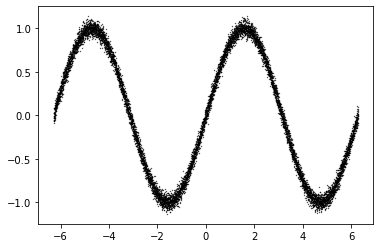

In [3]:
# 데이터를 생성한다.
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None] # 입력 데이터는 [−2𝜋, 2𝜋]에서 10000개의 각도를 등간격 샘플링하여 얻는다 => 벡터 1*10000
#np.linspace 함수: 선형 간격의 벡터 생성
# (ex) y = linspace(x1,x2)는 x1과 x2 사이에서 균일한 간격의 점 100개로 구성된 행 벡터를 반환. 여기서 n을 정해주면 그 개수만큼 샘플링함
# [:,None]는 길이가 1인 축을 만들어준다.

outputs = np.sin(inputs) + 0.05 * np.random.normal(size=[len(inputs),1]) # 출력 데이터는 sin(𝜃) + 0.05 * 𝒩(0,1) 이다, 표준 정규분포는 input과 동일하게 하기위해 size를 지정해줘여한다
#np.random.normal(평균, 표준편차)


plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')

## 모델 정의

In [4]:
# 모델은 tensorflow를 이용하여 만든다
# 여기서는 model 계층을 만들지 않고 가중치와 편향을 직접 입력하여 모델을 만든다.

class Model(tf.Module):
    def __init__(self): # 모델의 construction부분
        # create variables
        # weight와 bias는 tensor를 이용하여 정의한다
        initializer = tf.initializers.GlorotUniform() # 초기화함수

        # weight값은 초기화함수를 이용해 정의한다.
        W0 = tf.Variable(initializer(shape=[1, 20]), dtype=tf.float32, name='W0')
        W1 = tf.Variable(initializer(shape=[20, 20]), dtype=tf.float32, name='W1')
        W2 = tf.Variable(initializer(shape=[20, 1]), dtype=tf.float32, name='W2')

        # bias값은 zeros함를 이용해 정의한다
        b0 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b0')
        b1 = tf.Variable(tf.zeros(shape=[20]),dtype=tf.float32, name='b1')
        b2 = tf.Variable(tf.zeros(shape=[1]), dtype=tf.float32, name='b2')

        self.weights = [W0, W1, W2]
        self.biases = [b0, b1, b2]
        self.activations = [tf.nn.relu, tf.nn.relu, None] # 첫번째 계층은 relu, 두번째 계층도 relu, output layer는 항등함수로 None
    
    def __call__(self, x): # 가중합산과 actiavtion부분
        layer = x
        for W, b, activation in zip(self.weights, self.biases, self.activations):
            layer = tf.matmul(layer, W) + b #matmul 함수를 이용해 가중합산한다
            if activation is not None:
                layer = activation(layer)
        output_pred = layer
    
        return output_pred

## 모델 훈련

In [5]:
# 모델 훈련은 GradientTape 방식 이용

model = Model()
optimizer = tf.optimizers.Adam() # optimizer는 Adam 사용

# run training
batch_size = 32
for training_step in range(10000): # batch_size만큼씩 만번 돌린다
    # get a random subset of the training data
    # input과 output에 대한 배치를 만들어야한다
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size) # batch_size만큼 inputs에서 랜덤으로 인덱스 수를 뽑는다
    input_batch = tf.Variable(inputs[indices], dtype=tf.float32, name='input') 
    output_batch = tf.Variable(outputs[indices], dtype=tf.float32, name='output')
    
    # gradientTape을 이용해 예측한다
    with tf.GradientTape() as tape:
        output_pred = model(input_batch) #model에 input_batch를 넣었을때 예측 값
        # mean squared error를 구해야한다 -> 회귀문제 loss값
        # mean squared error는 먼저 예측 값 - 타켓값을 뺀 값에 제곱을 한다 => tf.square(output_pred - output_batch)
        # 참고로, output_pred - output_batch는 32*1형태의 vector이고 이를 square하면 scalar값이 된다.
        # 그런 다음 전체 평균에 대한 값을 구하기 위해 tf.reduce_mean함수를 사용하면 된다.

        mse = tf.reduce_mean(tf.square(output_pred - output_batch))

        # tape.gradient를 통해 gradient를 구한다 -> 모델의 파라미터(모델의 tf.Variable로 선언된 것들)는 model.trainable_variables를 통해 얻을 수 있다
        grads  = tape.gradient(mse, model.trainable_variables)
        # optimizer는 apply_gradients함수를 사용해서 모델의 파라미터를 update해야한다 
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    #loss값은 점점 줄어 들어 거의 오차가 없어진다
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse))

0000 mse: 0.486
1000 mse: 0.080
2000 mse: 0.068
3000 mse: 0.065
4000 mse: 0.042
5000 mse: 0.009
6000 mse: 0.005
7000 mse: 0.003
8000 mse: 0.005
9000 mse: 0.003


## 테스트

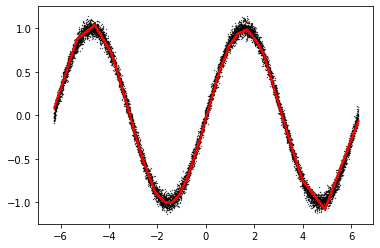

In [6]:
test_input = tf.Variable(inputs, dtype=tf.float32, name='input')
test_output = tf.Variable(outputs, dtype=tf.float32, name='output')
test_output_pred = model(test_input)

plt.scatter(inputs[:, 0], test_output[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], test_output_pred[:, 0], c='r', marker='o', s=0.1)